# Задание

Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). 

4. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3).

5. Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 0.1 до 0.5, monetary от 55 до 72 баллов. 

*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [1]:
# загружаем библиотеки

import pandas as pd

In [15]:
# выгружаем исходные данные 

""" описание исходных данных
assessments -  этот файл содержит информацию об оценках в тесте. 
Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест

courses.csv — файл содержит список предметов по семестрам.

studentAssessment.csv — этот файл содержит результаты тестов студентов. 
Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

studentRegistration.csv — этот файл содержит информацию о времени, когда студент зарегистрировался 
для прохождения курса в семестре.
"""

assessments = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/first_project/assessments.csv', sep=',', parse_dates=True)
courses = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/first_project/courses.csv', sep=',',  parse_dates=True)
studentAssessment = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/first_project/studentAssessment.csv', sep=',',  parse_dates=True)
studentRegistration = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/first_project/studentRegistration.csv', sep=',',  parse_dates=True)

# 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

In [16]:
""" Курс = Предмет. По некоторым экзаменам дата сдачи теста  = NaN, такие экзамены тоже засчитываем.Возможно в расписании забыли проставить дату, 
но по данным видно, что студенты экзамены все равно сдавали """

# объединяем результаты тестов и оценки в тестах

data_result_assessment = studentAssessment.merge(assessments, on='id_assessment')

In [17]:
# Проверяем какие типы теста пересдают, экзаменов среди нет, поэтому пересдачу в итоговом подсчете не учитываем

data_result_assessment.query('is_banked ==1')['assessment_type'].unique()

array(['TMA', 'CMA'], dtype=object)

In [18]:
# объединяем результаты тестов и оценки в тестах c датами регистрации на курс

final_df = data_result_assessment.merge(studentRegistration, on=['code_module','id_student','code_presentation'])

In [20]:
""" В качестве ответа будем брать те предметы, по которым 
1. проходил экзамен 
2. студент не отменял регистрацию на курс
3. score >= 40 """


final_df.query('assessment_type =="Exam" and date_unregistration=="NaN" and score >= 40').\
                groupby('id_student', as_index=False).\
                 agg({'code_module':'count'}).\
                 query('code_module == 1').count()


id_student     3802
code_module    3802
dtype: int64

Вывод: всего 3802 успешно сдали только 1 курс

# Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*
завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [22]:
"""считаем кол-во успешных экзаменов : (тип теста - экзамен, оценка> 40, нет даты отмены регистрации) """

cnt_success_exm = final_df.query('assessment_type =="Exam" and score>= 40 and date_unregistration=="NaN"').\
                groupby(['id_assessment','code_module'], as_index=False).\
                agg({'id_student':'count'}).\
                rename(columns={'id_student': 'count_success_exm'})

In [23]:
""" считаем общее кол-во попыток сдачи экзаменов """

cnt_tries_exm = final_df.query('assessment_type =="Exam"').\
                groupby(['id_assessment','code_module'], as_index=False).\
                agg({'id_student':'count'}).\
                rename(columns={'id_student': 'count_exm'})

In [24]:
""" объединяем датасеты """

info_exm = cnt_success_exm.merge(cnt_tries_exm, on=['id_assessment','code_module'])

In [25]:
""" рассчитываем новое значение Завершаемость путем добавления нового столбца в df """

info_exm['completion'] = round((info_exm.count_success_exm / info_exm.count_exm) *100,2)

In [26]:
""" для определения самого сложного экзамена используем сортировку по убыванию относительно завершаемости и берем первую запись """

info_exm.sort_values(by='completion', ascending=False).head(1)

,id_assessment,code_module,count_success_exm,count_exm,completion
4,25361,DDD,485,524,92.56


In [27]:
""" для определения самого простого экзамена используем сортировку по возрастанию относительно завершаемости и берем первую запись """

info_exm.sort_values(by='completion', ascending=True).head(1)

,id_assessment,code_module,count_success_exm,count_exm,completion
2,25340,DDD,504,602,83.72


# Итоговый ответ: 

самый простой экзамен 25361 в рамках курса DDD, завершаемость 92.56%
самый сложный экзамен 25340 в рамках курса DDD, завершаемость 83.72%

# 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). 

In [30]:
""" В качестве срока сдачи экзамена будем брать date_submitted (дата сдачи теста студентом), пересдачи не учитываем при подсчете
Определяем список студентов, которые успешно сдали экзамен и максимальные даты  """

max_day = final_df.query('assessment_type =="Exam" and score>=40 and date_unregistration=="NaN"')[{'id_student','code_module','date_submitted','code_presentation'}].\
                    groupby(['id_student','code_module'], as_index=False).max()

In [31]:
"""  Определяем средний срок сдачи по каждому предмету """ 

max_day.groupby('code_module', as_index=False).agg({'date_submitted':'mean'}).round(0)

,code_module,date_submitted
0,CCC,239.0
1,DDD,238.0


# Итоговый ответ: 

по предмету CCC средний срок сдачи 239 дней
по предмету DDD средний срок сдачи 238 дней

# 4. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3). (8 баллов)

In [33]:
""" При подсчете популярных курсов будем учитывать все типы тестов. Если студент отменял регистрацию, то такую регистрацию на курс в общем кол-ве не учитываем.
Регистрации на курс не ограничиваются каким-то определенным семестром """

# топ-3 популярных курсов
final_df.query('date_unregistration == "NaN"').\
    groupby('code_module', as_index=False).\
    agg({'id_student':'count'}).\
    rename(columns={'id_student': 'count_register'}).\
    sort_values(by='count_register', ascending=False).head(3)

,code_module,count_register
5,FFF,51418
1,BBB,40339
3,DDD,27341


# Итоговый ответ:

 ТОП -3 популярных курса по количеству регистраций: FFF, BBB, DDD


In [36]:
""" оттоком будем считать факт того, что по студенту date_unregistration не пустое -> в рамках каждого курса будем считать кол-во date_unregistration не пустое по каждому тесту
и выбирать 3 курса с максимальным кол-вом

при подсчете оттока будут учитываться все типы тестирования и все семестры
также будут учитываться как отток пересдачи при условии что date_unregistration не пустое  """

# топ-3 курса с max оттоком
final_df.query('date_unregistration != "NaN"').\
groupby('code_module', as_index=False).\
agg({'id_assessment':'count'}).\
rename(columns={'id_assessment': 'count_churn'}).\
sort_values(by='count_churn', ascending=False).head(3)

,code_module,count_churn
3,DDD,3523
5,FFF,3397
1,BBB,2693


# Вывод:

Видимо самые популярные курсы -  FFF, BBB, DDD - и самые сложные, раз одни и те же курсы находятся и в топе оттока

# Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 

In [49]:
""" Описание используемых переменных 
#df1 - studentRegistration
#df2 - studentAssessment
#df3 - assessments

На вход в функцию должны подаваться соответствующие датафреймы

"""
def cohorts(df1, df2, df3):
    
    # Присваиваем когорту каждому студенту по первому семестру, в котором произошла первая регистрация на любой курс 
    # с любым типом теста
    student_cohort = df1.groupby(['id_student'], as_index=False).agg({'code_presentation':'min'}).rename(columns={'code_presentation':'cohort'})
        
    #формируем отдельный df с семестрами
    semestr_order =pd.DataFrame(['2013B','2013J','2014B', '2014J'])
    semestr_order.columns = ['semestr']
    
    #задаем ключи для джойна
    semestr_order['key']= 1
    student_cohort['key']= 1
    
    # соединяем когорты и семестры по каждому студенту
    template = semestr_order.merge(student_cohort, on='key')[{'semestr','id_student','cohort'}]
    
    # оставляем только те семестры в общем df, с которых происходит первая регистрация по каждому студенту
    template = template[template['semestr'] >= template['cohort']]
    template.columns = ['cohort','id_student','code_presentation']
    
    # объединяем результаты тестов, оценки в тестах,когорты
    data = df2.merge(df3, on='id_assessment').merge(df1, on=['code_module','code_presentation','id_student'])
 
    # считаем кол-во успешных экзаменов по каждому студенту в разрезе семестра
    success_exm = data.query('assessment_type =="Exam" and score>40 and date_unregistration=="NaN"').groupby(['id_student','code_presentation'], as_index=False).agg({'id_assessment':'count'}).rename(columns={'id_assessment':'cnt_success_exm'})
   
    # считаем общее кол-во попыток сдать экзамен по каждому студенту в разрезе семестра
    count_exm = data.query('assessment_type =="Exam" and date_unregistration=="NaN"').groupby(['id_student','code_presentation'], as_index=False).agg({'id_assessment':'count'}).rename(columns={'id_assessment':'cnt_exm'})
        
    # объединяем данные по попыткам и успехам и рассчитываем % соотношение по каждому семестру
    exm = success_exm.merge(count_exm, on =['code_presentation','id_student'])
  
    #completion
    exm['completion'] = exm['cnt_success_exm'] / exm['cnt_exm']
    
    # объединяем результаты с когортами
    report = exm.merge(template, on = ['code_presentation','id_student'])
    
    # Определяем список студентов, которые успешно сдали экзамен и максимальные даты  
    max_day = data.query('assessment_type =="Exam" and score>40 and date_unregistration=="NaN"')[{'id_student','code_module','date_submitted','code_presentation'}].\
    groupby(['id_student','code_presentation'], as_index=False).max()
  

    report_total = report.merge(max_day, on=['code_presentation','id_student'])
    final = report_total.pivot_table(index='cohort', columns='code_presentation', values='completion')
     
    return final

In [50]:
cohorts(studentRegistration,studentAssessment,assessments )

code_presentation,2013B,2013J,2014B,2014J
cohort,,,,
2013B,1.0,1.0,1.000000,0.964286
2013J,NaN,1.0,1.000000,1.000000
2014B,NaN,NaN,0.999449,1.000000
2014J,NaN,NaN,NaN,0.998899


# Вывод

семестр с самой низкой завершаемостью курсов - 2014J у когорты студентов, которые регистрировались в 2013B

In [53]:
""" Описание используемых переменных 
#df1 - studentRegistration
#df2 - studentAssessment
#df3 - assessments

На вход в функцию должны подаваться соответствующие датафреймы

"""

def avg_time(df1, df2, df3):
    
    # Присваиваем когорту каждому студенту по первому семестру, в котором произошла первая регистрация на любой курс 
    # с любым типом теста
    student_cohort = df1.groupby(['id_student'], as_index=False).agg({'code_presentation':'min'}).rename(columns={'code_presentation':'cohort'})
        
    #формируем отдельный df с семестрами
    semestr_order =pd.DataFrame(['2013B','2013J','2014B', '2014J'])
    semestr_order.columns = ['semestr']
    
#     #задаем ключи для джойна
    semestr_order['key']= 1
    student_cohort['key']= 1
    
# #     # соединяем когорты и семестры по каждому студенту
    template = semestr_order.merge(student_cohort, on='key')[{'semestr','id_student','cohort'}]
    
#     # оставляем только те семестры в общем df, с которых происходит первая регистрация по каждому студенту
    template = template[template['semestr'] >= template['cohort']]
    template.columns = ['cohort','id_student','code_presentation']
 
 #     # объединяем результаты тестов, оценки в тестах,когорты
    data = df2.merge(df3, on='id_assessment').merge(df1, on=['code_module','code_presentation','id_student'])
 
    
# #     # Определяем список студентов, которые успешно сдали экзамен и максимальные даты  
    max_day = data.query('assessment_type =="Exam" and score>40 and date_unregistration=="NaN"')[{'id_student','code_module','date_submitted','code_presentation'}].\
    groupby(['id_student','code_presentation'], as_index=False).max()

    avg_date = max_day.groupby('code_presentation', as_index=False).agg({'date_submitted':'mean'}).round(0).rename(columns={'date_submitted':'avg_date'})
    
# #     # объединяем результаты с когортами
    report = avg_date.merge(template, on = ['code_presentation'])
 
    final = report.pivot_table(index='cohort', columns='code_presentation', values='avg_date')
  
    return final

In [54]:
avg_time(studentRegistration,studentAssessment,assessments )

code_presentation,2013B,2013J,2014B,2014J
cohort,,,,
2013B,230.0,240.0,233.0,244.0
2013J,NaN,240.0,233.0,244.0
2014B,NaN,NaN,233.0,244.0
2014J,NaN,NaN,NaN,244.0


# Вывод

семестр с  самыми долгими средними сроками сдачи курсов - 2014J

Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики:  R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен.

In [56]:
""" объединяем датафреймы """
data = assessments.query("assessment_type == 'Exam'")[['code_presentation', 'id_assessment', 'code_module']] \
                        .merge(courses, on = ['code_module', 'code_presentation']) \
                        .merge(studentAssessment, on = 'id_assessment') 


In [57]:
""" создаем флаг успешно сданного экзамена """
data['passed_exm'] = (data['score'] >= 40)*1

In [58]:
""" определяем по студенту среднюю дату сдачи, среднюю оценку, кол-во экзаменов, кол-во успешно сданных экзаменов """
df = data.groupby('id_student', as_index = False)\
                            .agg({'date_submitted':'mean',
                                  'score': 'mean',
                                  'id_assessment': 'count',
                                  'passed_exm': 'sum'})

""" добавляем новый признак - завершаемость"""
df['completion'] = df.passed_exm / df.id_assessment

In [59]:
""" формируем кластеры по дате сдачи, завершаемости и оценкам """
total = df[['id_student', 'date_submitted', 'completion', 'score']] \
                        .rename(columns = {'date_submitted': 'R',
                                           'completion' : 'F',
                                           'score' : 'M'})

In [60]:
# для разделения проверим кластер R, будем брать процентили
total.R.describe()

count    4633.000000
mean      238.462227
std         5.653378
min       229.000000
25%       234.000000
50%       241.000000
75%       243.000000
max       285.000000
Name: R, dtype: float64

In [61]:
""" разделим кластер R на 4 части """
total['R_cluster'] = pd.qcut(total['R'], 4, ['1','2','3','4'])

In [62]:
""" по завершаемости курсов есть 3 уникальных значения
условно их можно поделить на :
1 - не сдал ни один экзамен (значения 0 - 0.25 )
2 - сдал один экзамен из 2х (значения 0.26 - 0.8)
3 - сдал два экзамена (значения 0.81 - 1)"""
total['F'].unique()


array([1. , 0. , 0.5])

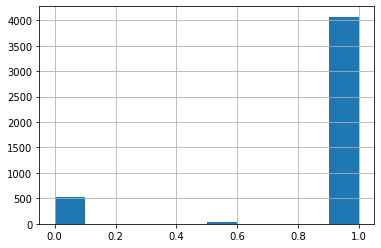

In [63]:
# значения распределяются неравномерно -> будем использовать cut чтобы задать интервалы самостоятельно
total['F'].hist()


In [64]:
total['F'].value_counts()

1.0    4069
0.0     536
0.5      28
Name: F, dtype: int64

In [65]:
""" разбивка на интервалы """
bins = [0, 0.25, 0.8, 1]
labels = ['1', '2', '3']
total['F_cluster'] = pd.cut(total['F'], bins, labels = labels )

In [66]:
total['F_cluster'].value_counts()

3    4069
2      28
1       0
Name: F_cluster, dtype: int64

4633

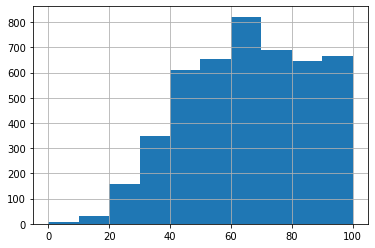

In [67]:
""" По среднему баллу студентов разделим на кластеры:

М < 40 - не сдал - кластер 4
далее с шагом в 20 баллов:
40-69 баллов - тройка, кластер 3
70-89 баллов - четверка, кластер 2
90-100 - пятерка, кластер 1 """

total['M'].hist()
total['M'].count()

In [68]:
""" разбивка на интервалы """
bins = [0, 39, 69, 89, 100]
labels = ['4','3','2', '1']
total['M_cluster'] = pd.cut(total['M'], bins, labels = labels )

In [69]:
total['M_cluster'].value_counts()
total['M_cluster'].count()

4630

In [70]:
total['M_cluster'].unique()

['2', '3', '1', '4', NaN]
Categories (4, object): ['4' < '3' < '2' < '1']

In [71]:
# нулевые оценки отнесем к не сдавшим, 4 кластер
total['M_cluster'] = total['M_cluster'].cat.add_categories('nan').fillna('4')
total

,id_student,R,F,M,R_cluster,F_cluster,M_cluster
0,23698,243.0,1.0,80.0,3,3,2
1,24213,236.0,1.0,58.0,2,3,3
2,27116,243.0,1.0,96.0,3,3,1
3,28046,237.0,1.0,40.0,2,3,3
4,28787,243.0,1.0,44.0,3,3,3
...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,2,3,3
4629,2694933,230.0,1.0,73.0,1,3,2
4630,2695608,237.0,1.0,73.0,2,3,2
4631,2697181,230.0,1.0,80.0,1,3,2


In [72]:
""" переводим значения в строку и склеиваем, чтобы посмотреть сегменты"""

total['RFM'] = total.R_cluster.astype(str) + total.F_cluster.astype(str)+ total.M_cluster.astype(str)

In [73]:
total

,id_student,R,F,M,R_cluster,F_cluster,M_cluster,RFM
0,23698,243.0,1.0,80.0,3,3,2,332
1,24213,236.0,1.0,58.0,2,3,3,233
2,27116,243.0,1.0,96.0,3,3,1,331
3,28046,237.0,1.0,40.0,2,3,3,233
4,28787,243.0,1.0,44.0,3,3,3,333
...,...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,2,3,3,233
4629,2694933,230.0,1.0,73.0,1,3,2,132
4630,2695608,237.0,1.0,73.0,2,3,2,232
4631,2697181,230.0,1.0,80.0,1,3,2,132
